# Índice
1. [Importación de Dependencias](#importación-de-dependencias)
2. [Configuración del Notebook](#configuración-del-notebook)
    1. [Configuración Global](#configuracion-global)
    2. [Configuración de la Predicción](#configuracion-de-la-prediccion)
    3. [Configuración de Hiperparámetros](#configuracion-de-hiperparametros)
3. [Funciones Auxiliares](#funciones-auxiliares)
    1. [getDataFramesForTrainAndTest()](#getdataframesfortrainandtest)
    2. [getMegaDF()](#getmegadf)
    3. [adjustDataFrameForUseCase()](#adjustdataframeforusecase)
    4. [enrichDF()](#enrichdf)
    5. [initializeResumeData()](#initializeresumedata)
4. [Creación del CSV Agregado](#creación-del-csv-agregado)
5. [Exploración de los datos](#exploración-de-los-datos)
    1. [Evaluación de los datos nulos](#evaluación-de-datos-nulos-)
    2. [Tipos de tiendas](#tipos-de-tiendas)
    3. [Exploración de las ventas por tipo de tienda](#exploración-de-las-ventas-por-tipo-de-tienda)
    4. [Evaluación de las ventas por temporalidad](#evaluación-de-ventas-por-temporalidad)
    5. [Información del tipo de columnas](#información-del-tipo-de-las-columnas)
6. [Evaluador Masivo de Modelos de Predicción](#evaluador-masivo-de-modelos-de-predicción)
    1. [Enriquecimiento del DataSet](#enriquecimiento-del-dataset)
        1. [Evaluación de los datos nulos](#evaluación-de-datos-nulos--1)
        2. [Total datos para el entrenamiento](#total-datos-para-el-entrenamiento)
    2. [Pipelines de Preprocesamiento](#pipelines-de-preprocesamiento)
        1. [Normalización de datos y PCA](#normalización-de-datos-y-pca)
    3. [PCA. Análisis de las Componentes Principales](#pca-análisis-de-las-componentes-principales)
        1. [Varianza por Componente Principal](#varianza-por-componente-principal)
        2. [Varianza Acumulada](#varianza-acumulada)
    4. [Pipelines de Predicción](#pipelines-de-predicción)
        1. [Pipeline - Regresión Lineal](#pipeline---regresión-lineal)
        2. [Pipeline - Árboles de Decisión](#pipeline---árboles-de-decisión)
        3. [Pipeline - Lasso](#pipeline---lasso)
        4. [Pipeline - Bosques Aleatorios](#pipeline---bosques-aleatorios)
        5. [Pipeline - Stacking Regressor](#pipeline---stacking-regressor)
    5. [Motor de Evaluación](#motor-de-evaluación)


# Importación de dependencias

In [1]:
import pandas as pd
import time
import  os
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore') 
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from IPython.display import display
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
# Pipelines Dependencies
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import seaborn as sns
# Machine Learning Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from IPython.core.display import HTML

# Configuración del Notebook

## Configuración Global

In [2]:
# Configuración de Directorios
data_directory = "data"
csv_evaluation_resume = "csv_evaluation_resume.csv"
store_csv_path = data_directory + "/store.csv"
store_data_csv_path = data_directory + "/store-data.csv"

# Configuramos el número de ventanas temporales y los días que se recuperan del
# dataset global.
windows = [
    7, 
    15, 
    30, 
    60,
    90, 
   120, 
   180, 
   365, 
   730, 
   1095
]

# Configuramos por cada ventana temporal el porcentaje de datos que se usarán
# para el entrenamiento.
percents_by_windows = [
    1.0, 
   0.90, 
   0.75, 
   0.5, 
   0.25, 
   0.1, 
   0.05, 
   0.01
]

# Cargamos los ficheros CSV en DataFrames de pandas
storeDF = pd.read_csv(store_csv_path)
storeDataDF = pd.read_csv(store_data_csv_path)

# Esta variable permite definir las columnas que se eliminarán del DataFrame
# que no vamos a usar en el TFM en ningún caso de uso.
columns_to_drop = [
]

# Esta variable permite definir el porcentaje de datos que se usarán para 
# el entrenamiento
percent_train = 0.8

scoring = {'r2':'r2','rmae':'neg_root_mean_squared_error','mae':'neg_mean_squared_error'}

## Configuración de la Predicción

In [3]:
# Con el DataSet enriquecido, esta variable nos permite seleccionar
# que columnas queremos usar para el entrenamiento
columns_for_inference = [
	#"Store", ojo
    "StoreType",
    "Assortment",
    "Promo2", 
    "Promo2SinceWeek",	
    "Promo2SinceYear",
    "DayOfWeek", 
    "Customers",	
    "Open",	
    "Promo",	
    "StateHoliday",
    "SchoolHoliday",
    "SalesDay",
    "SalesMonth",
    "SalesYear",
    "PromoIntervalMonth1", 
    "PromoIntervalMonth2", 
    "PromoIntervalMonth3", 
    "PromoIntervalMonth4",
    "CompetitionOpenSinceYear",
    "CompetitionDistance",
    "CompetitionOpenSinceMonth"
]

# Esta variable define que columna que se usará para predecir
column_to_predict = 'Sales'

## Configuración de Hiperparámetros
En esta sección se configuran los hiperparámetros que utilizarán los modelos de predicción

In [4]:
pca_no_componentes = 16
pipeline_random_state = 42

# Lasso - Hiperparámetros
lasso_alpha = 1
lasso_selection = 'cyclic'
lasso_max_iter = 5
lasso_tol = 1e-05
lasso_final_max_iter = 50
lassos_final_tot = 1e-04

# Decision Tree Regressor - Hiperparámetros
dtr_max_depth = 15
dtr_min_samples_leaf = 3
dtr_min_samples_split = 8

# Random Forest Regressor - Hiperparámetros
rfr_n_estimators = 10

# Funciones Auxiliares
En esta sección están codificadas las funciones auxiliares que necesita el motor de evaluación.

## getDataFramesForTrainAndTest()
Esta función se encarga de obtener los datos de entrenamiento y test a partir del dataframe
generado por la función anterior, permitiendo decidir en esta función, que columnas se usarán
para inferir y cual se utilizará para predecir. Los argumentos que recibe son:
- `dataFrame`: DataFrame que contiene los datos mergeados de los ficheros CSV.
- `percent_train`: Porcentaje de datos que se utilizarán para entrenar
- `columns_for_inference`: columnas que se utilizarán para inferir en los datos de entrenamiento y test
- `column_to_predict`: columna que se utilizará para predecir en los datos de entrenamiento y test

In [5]:
def getDataFramesForTrainAndTest(dataFrame, 
                                 percent_train, 
                                 columns_for_inference, 
                                 column_to_predict): 

    features = dataFrame[columns_for_inference]
    target = dataFrame[[column_to_predict]]

    return train_test_split(features, 
                            target, 
                            test_size=(1.0-percent_train), 
                            random_state=0)

## getMegaDF()
Esta función se encarga de obtener un Mega DataFrame (megaDF), unión de los dos CSV's en fichero y de eliminar aquellas columnas que no se usarán en ningún caso de uso del TFM
- `storeDF`: DataFrame que contiene los datos del archivo store.csv
- `storeDataDF`: DataFrame que contiene los datos del archivo store-data.csv
- `columns_to_drop`: Lista de columnas que queremos eliminar del Mega DataFrame

In [6]:
def getMegaDF(storeDF, 
              storeDataDF, 
              columns_to_drop):

    # Para poder tener todos los datos de entrada en una sola tabla 
    # mergeamos el DataFrame storeDF con el DataFrame storeDataDF 
    # por la columna Store
    megaDF = storeDF.merge(storeDataDF, on='Store')

    # Eliminamos las columnas del DataFrame mergeado que no
    # vamos a usar para la inferencia
    megaDF = megaDF.drop(columns=columns_to_drop)
    
    # Eliminamos las filas que contienen valores nulos
    # megaDF = megaDF.dropna() ojo
    
    # Reajustamos el tipo de la columna Date a datetime
    megaDF['Date'] = pd.to_datetime(megaDF['Date'])
        
    return megaDF

## adjustDataFrameForUseCase()
Esta función se encarga de ajustar el Mega DataFrame original al caso de uso que se quiere analizar en el TFM. Los argumentos de entrada que recibe son:
- `megaDF`: Mega DataFrame original de la unión de los CSV's sin las columnas innecesarias
- `last_no_days`: Número de días que queremos obtener a partir de la fecha más reciente
- `percent_of_returned_rows`: Porcentaje de filas que queremos obtener del DataFrame mergeado

In [7]:

def adjustDataFrameForUseCase(megaDF, 
                              last_no_days, 
                              percent_of_returned_rows):

    # Determinamos la fecha más reciente del DataFrame storeDataDF que nos 
    # servirá como pivote para obtener los datos de los últimos last_no_days días
    last_date = megaDF['Date'].max()

    # Determinamos la fecha mínima desde la cual queremos obtener registros
    # del DataFrame storeDataDF
    minDate = pd.to_datetime(last_date) - pd.DateOffset(days=last_no_days)

    # Reajustamos el tipo de la columna Date a datetime
    # megaDF['Date'] = pd.to_datetime(megaDF['Date']) ojo

    # Obtenemos los datos de storeDataDF a partir de la fecha minDate hasta la
    # fecha más reciente o last_date    
    megaDF = megaDF[megaDF['Date'] > minDate]

    # Obtener un porcentaje del total de filas del DataFrame
    # para poder hacer pruebas
    megaDF = megaDF.sample(frac=percent_of_returned_rows)
        
    return megaDF

## enrichDF()
Esta función la utilizaremos para enriquecer el CSV Agregado (megaDF) con nuevas columnas a partir de los datos que ya contiene y para convertir las columnas categóricas en columnas numéricas.
- `sourceDF`: Mega DataFrame que se va a enriquecer

In [8]:

def enrichDF(sourceDF):
    
    sourceDF['Date'] = pd.to_datetime(sourceDF['Date'])  # Ensure the Date column is in datetime format
    
    # Hacemos split de la columna Date en tres columnas nuevas: SalesDay, SalesMonth y SalesYear, que
    # permiten usar como numérico la fecha en String.
    sourceDF['SalesDay'] = sourceDF['Date'].dt.day
    sourceDF['SalesMonth'] = sourceDF['Date'].dt.month
    sourceDF['SalesYear'] = sourceDF['Date'].dt.year
    
    # Mapeamos los valores categóricos de la columna PromoInterval a valores numéricos
    month_mapping = {
        None:0, 
        'Jan': 1, 
        'Feb': 2, 
        'Mar': 3, 
        'Apr': 4, 
        'May': 5, 
        'Jun': 6, 
        'Jul': 7, 
        'Aug': 8, 
        'Sept': 9, 
        'Oct': 10, 
        'Nov': 11, 
        'Dec': 12
    }
    
    # Definimos las nuevas columnas a crear para cada valor de la columna PromoInterval
    promo_interval_columns = [
        'PromoIntervalMonth1', 
        'PromoIntervalMonth2', 
        'PromoIntervalMonth3', 
        'PromoIntervalMonth4'
    ]
    
    # Convertimos a String los valores de la columna PromoInterval
    sourceDF['PromoInterval'] = \
        sourceDF['PromoInterval'].astype(str)
    
    # Hacemos split de la columna PromoInterval en cuatro columnas nuevas
    sourceDF[promo_interval_columns] = \
        sourceDF['PromoInterval'].str.split(',', expand=True)
    
    # Mapeamos los valores de las nuevas columnas a valores numéricos y los valores no existentes pasan a ser cero
    sourceDF[promo_interval_columns] = \
        sourceDF[promo_interval_columns].applymap(month_mapping.get)
    
    # Eliminamos la columna PromoInterval
    sourceDF = sourceDF.drop('PromoInterval', axis=1)
    
    # Mapeamos los valores categóricos de la columna StateHoliday a valores numéricos
    state_holiday_mapping = {
        '0':0, 
        'a':1, 
        'b':2, 
        'c':3
    }
    # Convertimos a String los valores de la columna StateHoliday
    sourceDF['StateHoliday'] = \
        sourceDF['StateHoliday'].astype(str)
    
    # Mapeamos los valores de la columna StateHoliday a valores numéricos
    sourceDF['StateHoliday'] = \
        sourceDF['StateHoliday'].map(state_holiday_mapping)

    # Mapeamos los valores categóricos de la columna StoreType a valores numéricos
    story_type_mapping = {
        'a': 1,
        'b': 2,
        'c': 3,
        'd': 4
    }

    # Convertimos a String los valores de la columna StoreType
    sourceDF['StoreType'] = \
        sourceDF['StoreType'].astype(str)
    
    # Mapeamos los valores de la columna StoreType a valores numéricos
    sourceDF['StoreType'] = \
        sourceDF['StoreType'].map(story_type_mapping)
    
    # Mapeamos los valores categóricos de la columna Assortment a valores numéricos
    assortment_mapping = {
        'a': 1,
        'b': 2,
        'c': 3
    }

    # Convertimos a String los valores de la columna Assortment
    sourceDF['Assortment'] = \
        sourceDF['Assortment'].astype(str)
    
    # Mapeamos los valores de la columna Assortment a valores numéricos
    sourceDF['Assortment'] = \
        sourceDF['Assortment'].map(assortment_mapping)
    
    # Conjuntos de columnas  con nulos e imputación de los datos con ceros por ausencia de dato
    listado_columas_con_nullos = \
        ['Promo2SinceWeek','Promo2SinceYear'] + promo_interval_columns
    for columna in listado_columas_con_nullos:
        #inserción de ceros en los datos faltantes
        sourceDF[columna] = sourceDF[columna].fillna(0)
        #conversión de todos los valores a integer
        sourceDF[columna] = sourceDF[columna].astype(int)
    
    # Rellenar la distancia de la competencia con el valor de la mediana
    sourceDF['CompetitionDistance'].fillna(sourceDF['CompetitionDistance'].median(), inplace = True)
    
    # Rellenar el mes y año de apertura de la competencia con los valores más frecuentes de las columnas, es decir, las modas de esas columnas
    sourceDF['CompetitionOpenSinceMonth'].fillna(sourceDF['CompetitionOpenSinceMonth'].mode()[0], inplace = True)
    sourceDF['CompetitionOpenSinceYear'].fillna(sourceDF['CompetitionOpenSinceYear'].mode()[0], inplace = True)

    return sourceDF

In [9]:
def initializeResumeData():
    return {
        "use_case":[],
        "window":[],
        "data_size":[],
        "algorithm":[],
        "x_train_size":[],
        "y_train_size":[],
        "x_test_size" : [],
        "y_test_size": [],
        "mse":[],
        "mae":[],
        "r2":[],
        "time_train":[],
        "time_test":[]
    }

# Creación del CSV Agregado
En este punto se hace el join de las 2 CSV's que conforman el DataSet de Datos y eliminamos aquellas columnas que no queremos usar.

In [10]:
megaDF = \
    getMegaDF(storeDF, 
              storeDataDF, 
              columns_to_drop)

# Exploración de los datos

## Evaluación de datos nulos 

A continuación realizamos la evaluación individual de la cantidad de valores nulos existentes en el fichero store.csv 

In [11]:
display(storeDF.isna().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

A continuación realizamos la evaluación individual de la cantidad de valores nulos existentes en el fichero storeDataDF.csv 

In [12]:
print(storeDataDF.isna().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


Evaluación especifica de columnas de su total de nulos y no nulos por tipo de tienda y columna

In [13]:
# Agrupar por la columna 'Grupo' y verificar si hay nulos en cada grupo
grupos_con_nulos = megaDF.groupby('StoreType').apply(lambda x: x.isna().any().any())
# Filtrar los grupos que tienen valores nulos
grupos_con_nulos = grupos_con_nulos[grupos_con_nulos]
# Obtener los nombres de los grupos que tienen valores nulos
nombres_grupos_con_nulos = grupos_con_nulos.index
# Filtrar el DataFrame original para obtener solo los grupos con nulos
df_grupos_con_nulos = megaDF[megaDF['StoreType'].isin(nombres_grupos_con_nulos)]
#Tras la búsqueda de los datos, inicia evaluación individual
for storeType in ['a','b','c','d']:    
    #Hace la búsqueda de los datos por el tipo de tienda
    grupos_con_nulos = df_grupos_con_nulos[df_grupos_con_nulos.StoreType == storeType].isna().sum()
    #Reseteo de los datos para recuperar solo las columnas
    grupos_con_nulos = grupos_con_nulos.to_frame().reset_index()
    #Rename de la columna 0 a Total_Null
    grupos_con_nulos = grupos_con_nulos.rename(columns={0: "Total_Null"})   
    #Rename de la columna index a Columna
    grupos_con_nulos = grupos_con_nulos.rename(columns={'index': "Columnas"})
    #Extracción de los datos solo para aquellos con algún valor null
    grupos_con_nulos = grupos_con_nulos[grupos_con_nulos.Total_Null > 0]
    display(HTML(f'<b>Columnas con valores nulos vs no nulos para el tipo de tienda: {storeType}</b>'))
    # display(grupos_con_nulos)
    string_list_columna = [str(element) for element in grupos_con_nulos['Columnas'].tolist()]
    #contamos la cantidad de datos en la misma columna y no tiene nulos
    lst_no_nulos = []
    for columna in string_list_columna:
        #Hace la búsqueda de los datos por el tipo de tienda
        count_columna_con_no_nulos = megaDF[~megaDF[columna].isna() & megaDF.StoreType == storeType][columna].count()
        lst_no_nulos.append([columna, count_columna_con_no_nulos])
    #creamos el df de los totales sin nulos por tipo de columna
    grupos_not_null = pd.DataFrame(lst_no_nulos, columns=['Columnas', 'Total_not_null'])  
    #finalmente la unión de los dos df para obtener el total de nulos y no nulos
    result = grupos_con_nulos.merge(grupos_not_null, on=["Columnas"])
    display(result)

,Columnas,Total_Null,Total_not_null
0,CompetitionDistance,942,0
1,CompetitionOpenSinceMonth,161560,0
2,CompetitionOpenSinceYear,161560,0
3,Promo2SinceWeek,293741,0
4,Promo2SinceYear,293741,0
5,PromoInterval,293741,0


,Columnas,Total_Null,Total_not_null
0,CompetitionOpenSinceMonth,7352,0
1,CompetitionOpenSinceYear,7352,0
2,Promo2SinceWeek,11304,0
3,Promo2SinceYear,11304,0
4,PromoInterval,11304,0


,Columnas,Total_Null,Total_not_null
0,CompetitionOpenSinceMonth,37886,0
1,CompetitionOpenSinceYear,37886,0
2,Promo2SinceWeek,68582,0
3,Promo2SinceYear,68582,0
4,PromoInterval,68582,0


,Columnas,Total_Null,Total_not_null
0,CompetitionDistance,1700,0
1,CompetitionOpenSinceMonth,116550,0
2,CompetitionOpenSinceYear,116550,0
3,Promo2SinceWeek,134404,0
4,Promo2SinceYear,134404,0
5,PromoInterval,134404,0


Evaluación conjunta de todos nulos

In [14]:
print(megaDF.isna().sum())

Store                             0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
dtype: int64


## Tipos de tiendas
A continuación los tipos de tiendas.

In [15]:
display(storeDF['StoreType'].unique())

array(['c', 'a', 'd', 'b'], dtype=object)

Total datos por tipo de tiendas

## Exploración de las ventas por tipo de tienda

Observación de la distribucción de las ventas por tipo de tienda

In [16]:
megaDF.groupby(['StoreType'])['Sales'].agg(['sum'])

,sum
StoreType,
a,3165334859
b,159231395
c,783221426
d,1765392943


Además realizamos la evaluación de la representación en porcentaje de influencia del total de datos en las ventas por tienda

In [17]:
data = ((megaDF['StoreType'].value_counts()/megaDF['StoreType'].count())*100).to_frame()
data = data.rename(columns={'count': "Percentaje"})
data

,StoreType
a,54.229465
d,30.761820
c,13.452496
b,1.556219


## Evaluación de ventas por temporalidad

Visualización conjunta de las ventas por día de las semana

In [18]:
megaDFDay = megaDF[['Date','StoreType','Sales']]
megaDFDay['Day'] = megaDFDay['Date'].apply(lambda time: time.weekday() + 1)
data = megaDFDay.groupby(['Day'])['Sales'].agg(['sum']).stack().reset_index()
data = data.drop('level_1', axis=1)
data.index = data['Day']
data = data.drop('Day', axis=1)
data = data.rename(columns={0: "Total sale"})
display(data)

,Total sale
Day,
1,1130203012
2,1020411930
3,954962863
4,911177709
5,980555941
6,846317735
7,29551433


Visualización de ventas por cuatrimestre

In [19]:
megaDFDay = megaDF[['Date','StoreType','Sales']]
megaDFDay['Quarter'] = megaDFDay['Date'].apply(lambda time: time.quarter)
data = megaDFDay.groupby(['Quarter','StoreType'])['Sales'].agg(['sum']).stack().reset_index()
data = data.drop('level_2', axis=1)
data = data.rename(columns={0: "Total_sale"})
data

,Quarter,StoreType,Total_sale
0,1,a,910985204
1,1,b,43647817
2,1,c,223018787
3,1,d,517643232
4,2,a,923300815
5,2,b,47830906
6,2,c,225059826
7,2,d,527064740
8,3,a,705863011
9,3,b,35146522


## Información del tipo de las columnas

In [20]:
megaDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   StoreType                  1017209 non-null  object        
 2   Assortment                 1017209 non-null  object        
 3   CompetitionDistance        1014567 non-null  float64       
 4   CompetitionOpenSinceMonth  693861 non-null   float64       
 5   CompetitionOpenSinceYear   693861 non-null   float64       
 6   Promo2                     1017209 non-null  int64         
 7   Promo2SinceWeek            509178 non-null   float64       
 8   Promo2SinceYear            509178 non-null   float64       
 9   PromoInterval              509178 non-null   object        
 10  DayOfWeek                  1017209 non-null  int64         
 11  Date                       1017209 no

# Evaluador Masivo de Modelos de Predicción

## Enriquecimiento del DataSet
A partir del CSV Agregado en el paso anterior, en este punto y a través de la función enrichDF() se limpia y enriquecen las columnas del CSV convirtiendo las variables categóricas a variables numéricas que puedan ser interpretadas por los algoritmos de Machine Learning.

In [21]:
enrichedMegaDF = \
    enrichDF(megaDF)

### Evaluación de datos nulos 
Tras la conversión de los datos hacemos una última evalución de la cantidad de valores nulos.

In [22]:
print(enrichedMegaDF.isna().sum())

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
SalesDay                     0
SalesMonth                   0
SalesYear                    0
PromoIntervalMonth1          0
PromoIntervalMonth2          0
PromoIntervalMonth3          0
PromoIntervalMonth4          0
dtype: int64


### Total datos para el entrenamiento

In [23]:
len(enrichedMegaDF)

1017209

## Pipelines de Preprocesamiento
### Normalización de datos y PCA
En esta sección se configuran los step's de los pipeline's que se encargarán de normalizar los datos y de realizar PCA sobre los datos.

In [24]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
            ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, columns_for_inference),
    ]
)

pipeline_preprocessing = Pipeline(
    steps=[("preprocessor", preprocessor), ("pca",PCA())]
)

pipeline_preprocessing

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['StoreType', 'Assortment',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'DayOfWeek', 'Customers',
                                                   'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'SalesDay',
                                                   'SalesMonth', 'SalesYear',
                                                   'PromoIntervalMonth1',
                                                   'PromoIntervalMonth2',
                                                   'PromoIntervalMonth3',
                                                   'PromoIntervalMonth4',
                                                   'CompetitionOpenSinceYear',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth'])])),
                ('pca', PCA())])

## PCA. Análisis de las Componentes Principales
En esta sección evaluamos el análisis de las componentes principales con el objetivo de determinar que columnas son imporantes para el modelo

In [25]:
X = enrichedMegaDF[columns_for_inference]
Y = enrichedMegaDF[[column_to_predict]]
X.shape, Y.shape

((1017209, 21), (1017209, 1))

In [26]:
pipeline_preprocessing.fit(X,Y)
columns = X.columns.to_list()
# Se extrae el modelo entrenado del pipeline
modelo_pca = pipeline_preprocessing.named_steps['pca']

### Varianza por Componente Principal
En esta sección analizamos la importancia de cada columna en la predicción

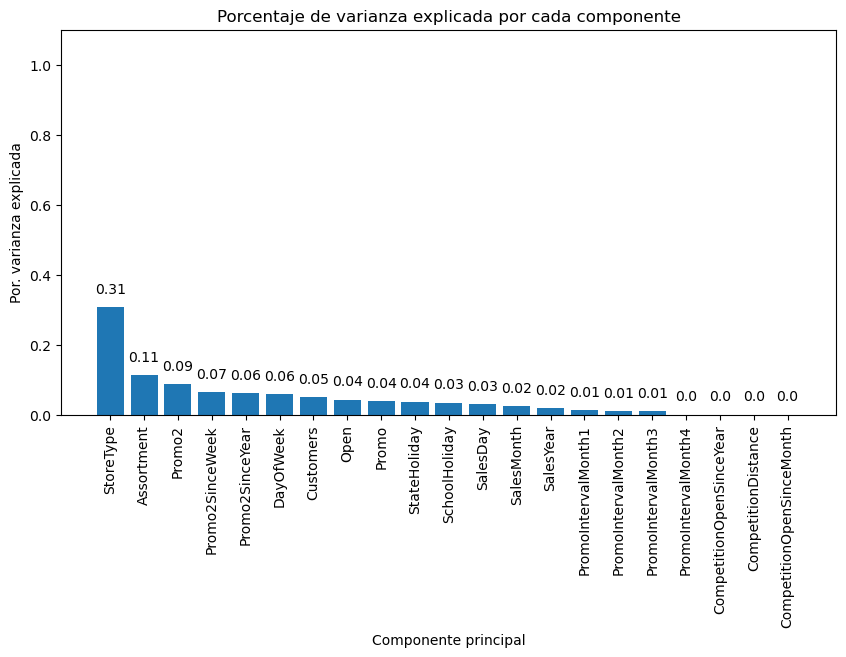

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_xticklabels(columns, rotation=90)
ax.set_ylabel('Por. varianza explicada')
plt.show()

### Varianza Acumulada
En esta sección analizamos la importancia aculada de cada columna en el modelo de predicción. De esta forma podemos observar cuando alcanzamos el 100 % de la varianza acumulada y que columnas son las que acumulan para llegar a ese 100 %.

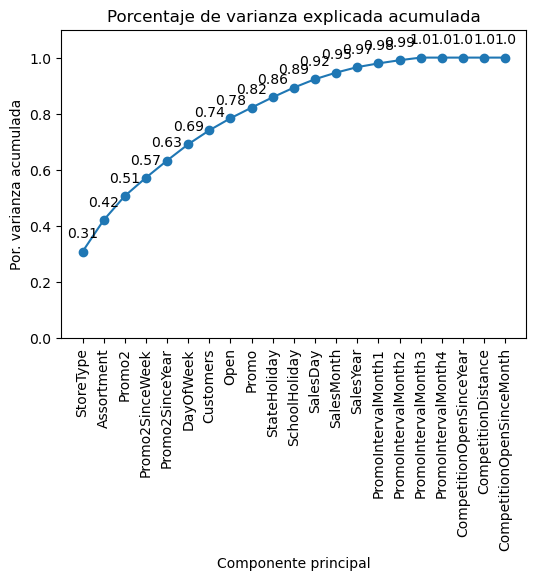

In [28]:
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_xticklabels(columns, rotation=90) 
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');
plt.show()

## Pipelines de Predicción

### Pipeline - Regresión Lineal

In [29]:
pipeline_linear_regression = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("pca",PCA(n_components = pca_no_componentes)), 
        ("clf", LinearRegression())]
)
pipeline_linear_regression

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['StoreType', 'Assortment',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'DayOfWeek', 'Customers',
                                                   'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'SalesDay',
                                                   'SalesMonth', 'SalesYear',
                                                   'PromoIntervalMonth1',
                                                   'PromoIntervalMonth2',
                                                   'PromoIntervalMonth3',
                                                   'PromoIntervalMonth4',
                                                   'CompetitionOpenSinceYear',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth'])])),
                ('pca', PCA(n_components=16)), ('clf', LinearRegression())])

### Pipeline - Árboles de Decisión

In [30]:
pipeline_decision_tree_regressor = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("pca", PCA(n_components = pca_no_componentes)), 
        ("clf", DecisionTreeRegressor(random_state=pipeline_random_state, 
                                      max_depth = dtr_max_depth, 
                                      min_samples_leaf = dtr_min_samples_leaf, 
                                      min_samples_split = dtr_min_samples_split))
    ]
)
pipeline_decision_tree_regressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['StoreType', 'Assortment',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'DayOfWeek', 'Customers',
                                                   'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'SalesDay',
                                                   'SalesMonth', 'SalesYear',
                                                   'PromoIntervalMonth1',
                                                   'PromoIntervalMonth2',
                                                   'PromoIntervalMonth3',
                                                   'PromoIntervalMonth4',
                                                   'CompetitionOpenSinceYear',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth'])])),
                ('pca', PCA(n_components=16)),
                ('clf',
                 DecisionTreeRegressor(max_depth=15, min_samples_leaf=3,
                                       min_samples_split=8, random_state=42))])

### Pipeline - Lasso

In [31]:
pipeline_lasso = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("pca",PCA(n_components = pca_no_componentes)), 
        ("clf", Lasso(random_state = pipeline_random_state, 
                      alpha = lasso_alpha, 
                      selection = lasso_selection, 
                      max_iter = lasso_max_iter, 
                      tol = lasso_tol))]
)
pipeline_lasso

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['StoreType', 'Assortment',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'DayOfWeek', 'Customers',
                                                   'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'SalesDay',
                                                   'SalesMonth', 'SalesYear',
                                                   'PromoIntervalMonth1',
                                                   'PromoIntervalMonth2',
                                                   'PromoIntervalMonth3',
                                                   'PromoIntervalMonth4',
                                                   'CompetitionOpenSinceYear',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth'])])),
                ('pca', PCA(n_components=16)),
                ('clf',
                 Lasso(alpha=1, max_iter=5, random_state=42, tol=1e-05))])

### Pipeline - Bosques Aleatorios

In [32]:
pipeline_random_forest_regressor = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("pca",PCA(n_components = pca_no_componentes)), 
        ("clf", RandomForestRegressor(random_state = pipeline_random_state, 
                                      n_estimators = rfr_n_estimators))
    ]
)
pipeline_random_forest_regressor

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['StoreType', 'Assortment',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear',
                                                   'DayOfWeek', 'Customers',
                                                   'Open', 'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday', 'SalesDay',
                                                   'SalesMonth', 'SalesYear',
                                                   'PromoIntervalMonth1',
                                                   'PromoIntervalMonth2',
                                                   'PromoIntervalMonth3',
                                                   'PromoIntervalMonth4',
                                                   'CompetitionOpenSinceYear',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth'])])),
                ('pca', PCA(n_components=16)),
                ('clf',
                 RandomForestRegressor(n_estimators=10, random_state=42))])

### Pipeline - Stacking Regressor

In [33]:
estimators = [
    ("Decision Tree Regressor", DecisionTreeRegressor(random_state=pipeline_random_state, 
                                                      max_depth = dtr_max_depth, 
                                                      min_samples_leaf = dtr_min_samples_leaf, 
                                                      min_samples_split = dtr_min_samples_split )),
    ("Lasso", Lasso(random_state = pipeline_random_state, 
                    alpha = lasso_alpha, 
                    selection = lasso_selection,
                    max_iter = lasso_max_iter, 
                    tol = lasso_tol)),
     ("Lineal Regression", LinearRegression()),
     ('Random Forest Regressor', RandomForestRegressor(random_state = pipeline_random_state, 
                                                       n_estimators = 5))
]

pipeline_Stacking_regressor = StackingRegressor (
    estimators=estimators,
    final_estimator=Lasso(random_state = pipeline_random_state, 
                          alpha = lasso_alpha, 
                          selection = lasso_selection,
                          max_iter = lasso_final_max_iter, 
                          tol = lassos_final_tot)) 

pipeline_Stacking_regressor

StackingRegressor(estimators=[('Decision Tree Regressor',
                               DecisionTreeRegressor(max_depth=15,
                                                     min_samples_leaf=3,
                                                     min_samples_split=8,
                                                     random_state=42)),
                              ('Lasso',
                               Lasso(alpha=1, max_iter=5, random_state=42,
                                     tol=1e-05)),
                              ('Lineal Regression', LinearRegression()),
                              ('Random Forest Regressor',
                               RandomForestRegressor(n_estimators=5,
                                                     random_state=42))],
                  final_estimator=Lasso(alpha=1, max_iter=50, random_state=42))

In [34]:
prediction_models_to_evaluate = [
    (pipeline_linear_regression, "Linear Regression"),
    (pipeline_decision_tree_regressor, "Decision Tree Regressor"),
    (pipeline_lasso, "Lasso"),
    (pipeline_random_forest_regressor, "Random Forest Regressor"), 
    (pipeline_Stacking_regressor, "Stacking Regressor")   
]


## Motor de Evaluación


In [35]:
# Inicializamos contadores
no_use_case = 1
no_total_use_cases = len(windows) * len(percents_by_windows)

# Inicializamos el diccionario de resultados de la evaluación
resultsData = \
    initializeResumeData()

scores = defaultdict(list)
symbols = ["⢎⡰", "⢎⡡", "⢎⡑", "⢎⠱", "⠎⡱", "⢊⡱", "⢌⡱", "⢆⡱"]

print("#########################################################")
print("# EVALUADOR DE MODELOS EN EJECUCIÓN - POR FAVOR, ESPERE #")      
print("#########################################################")
print("")
# Recorremos todas las ventanas temporales
for window in windows:
    
    index_percent = 0
    
    # Recorremos todos los porcentajes de datos que se usarán para el entrenamiento
    for percent_of_returned_rows in percents_by_windows:       
            
        symbol = symbols[no_use_case % len(symbols)]

        last_no_days = window

        # Obtenemos un DataFrame preparado para esta Ventana de Tiempo y
        # para el porcentaje de datos asociado
        useCaseDF = \
            adjustDataFrameForUseCase(enrichedMegaDF, 
                                      last_no_days, 
                                      percent_of_returned_rows)
        
        # Obtenemos los DataFrames de entrenamiento y test para ejecutar el
        # modelo
        X_train, X_test, Y_train, Y_test = \
            getDataFramesForTrainAndTest(useCaseDF, 
                                        percent_train, 
                                        columns_for_inference, 
                                        column_to_predict)
        
        df_model_date = useCaseDF['Date'].agg(['min', 'max'])

        # Creamos un identificador único para cada ventana
        id_use_case = "W" + str(window) + "P" + str(percent_of_returned_rows * 100)
        
        for i, (model, name) in enumerate(prediction_models_to_evaluate):
            
            data_percent = str(percent_of_returned_rows * 100)
            print(f"\r                                                                                                                        ", end="")
            print(f"\r{symbol} [{no_use_case} / {no_total_use_cases}] - Modelo [ {name} ] - Ventana [{window} días] - Datos [{data_percent} %]", end="")

            # Almacenamos detalles de la ejecución
            scores["use_case"].append(id_use_case)
            scores["window"].append(window)
            scores["data_size"].append(str(percent_of_returned_rows * 100))
            scores["algorithm"].append(name)
        
            # Almacenamos las fechas de principio y fin que se han tomado del csv de datos
            scores['max_date'].append(df_model_date['max'].strftime('%Y/%m/%d'))
            scores['min_date'].append(df_model_date['min'].strftime('%Y/%m/%d'))
            
            # Almacenamos el tamaño de los conjuntos de entrenamiento y test
            scores["x_train_size"].append(len(X_train))
            scores["y_train_size"].append(len(Y_train))
            scores["x_test_size"].append(len(X_test))
            scores["y_test_size"].append(len(Y_test))
            
            #################################################
            #   ESPACIDO PARA EL CÓDIGO FUENTE DEL MODELO   #
            #################################################
                   
            # Entrenar el modelo con los datos de entrenamiento
            start_time = time.perf_counter()
            model.fit(X_train, Y_train)
            end_time = time.perf_counter()
            scores['time_train'].append(end_time - start_time) 
            # Predecir los valores de la variable objetivo para los datos de prueba
            start_time = time.perf_counter()
            Y_pred = model.predict(X_test)
            end_time = time.perf_counter()
            scores['time_test'].append(end_time - start_time)               
    
            #######################################################
            #   ESPACIO PARA CALCULAR EL RENDIMIENTO DEL MODELO   #
            #######################################################
            
            for metric in [metrics.mean_absolute_error, metrics.r2_score]:
                score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
                scores[score_name].append(metric(Y_test, Y_pred))          
        
        index_percent += 1
        no_use_case += 1

resultsDF = pd.DataFrame(scores)
file_name = os.path.join(data_directory, csv_evaluation_resume)
resultsDF.to_csv(file_name, encoding='utf-8', index=False)

display(resultsDF)

#########################################################
# EVALUADOR DE MODELOS EN EJECUCIÓN - POR FAVOR, ESPERE #
#########################################################

⢎⡰ [80 / 80] - Modelo [ Stacking Regressor ] - Ventana [1095 días] - Datos [1.0 %]                                      

,use_case,window,data_size,algorithm,max_date,min_date,x_train_size,y_train_size,x_test_size,y_test_size,time_train,time_test,Mean absolute error,R2
0,W7P100.0,7,100.0,Linear Regression,2015/07/31,2015/07/25,6244,6244,1561,1561,0.082823,0.005654,1025.135664,0.864754
1,W7P100.0,7,100.0,Decision Tree Regressor,2015/07/31,2015/07/25,6244,6244,1561,1561,0.392044,0.005762,1103.334700,0.835503
2,W7P100.0,7,100.0,Lasso,2015/07/31,2015/07/25,6244,6244,1561,1561,0.061395,0.006214,1027.244125,0.864237
3,W7P100.0,7,100.0,Random Forest Regressor,2015/07/31,2015/07/25,6244,6244,1561,1561,2.865238,0.009485,864.435490,0.896909
4,W7P100.0,7,100.0,Stacking Regressor,2015/07/31,2015/07/25,6244,6244,1561,1561,2.234032,0.010887,727.693524,0.929394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,W1095P1.0,1095,1.0,Linear Regression,2015/07/31,2013/01/01,8137,8137,2035,2035,0.063115,0.005132,979.695637,0.868899
396,W1095P1.0,1095,1.0,Decision Tree Regressor,2015/07/31,2013/01/01,8137,8137,2035,2035,0.497630,0.005709,1160.995079,0.805610
397,W1095P1.0,1095,1.0,Lasso,2015/07/31,2013/01/01,8137,8137,2035,2035,0.073026,0.005562,979.906250,0.868872
398,W1095P1.0,1095,1.0,Random Forest Regressor,2015/07/31,2013/01/01,8137,8137,2035,2035,4.465952,0.011887,895.444177,0.883707


In [36]:
from sinfo import sinfo
sinfo()

ModuleNotFoundError: No module named 'sinfo'